In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import GPy

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from IPython.display import display

In [3]:
np.random.seed(123) # Initialize random number generator

## Motivation
When using Gaussian process models, it is often challenging but important to choose a kernel carefully. This is because the choice of kernel determines the expressiveness and generalization properties of the model.

Since the kernel defines the covariance between any two data points, it encodes our belief about the underlying structure of the data. For instance, a squared exponential kernel assumes that the data follows a relatively smooth pattern.

In the following, we will see how a good choice of kernels can help discover complex underlying structure in a dataset. The dataset used here is the classic Mauna Loa data from Rasmussen & Williams (2006).

## Kernel selection

Fortunately, there's a large selection of kernels to choose from. Here are several commonly used kernels:

 - Squared exponential  - for relatively smooth functions
 - Periodic - for oscillations
 - Matérn - for varying smoothness
 - Rational quadratic - for varying length scales
 
Furthermore, you can add or multiply kernels together. By composing kernels in this way, Gaussian processes can capture complex relationships in data which do not have a simple parametric form. And better still, the kernel parameters reveal intuitive and useful explanations about the structure of the data.

For more details about kernel engineering:<br>
http://www.cs.toronto.edu/~duvenaud/cookbook/

 /Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


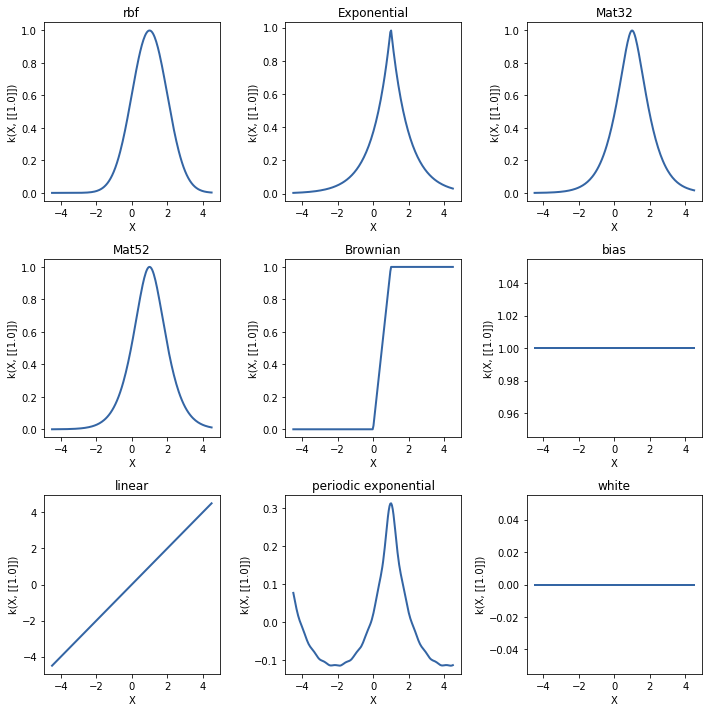

In [4]:
figure, axes = plt.subplots(3,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), GPy.kern.Matern52(1), GPy.kern.Brownian(1), GPy.kern.Bias(1), GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1)]
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))

## Manau Loa dataset
Now, let's perform GP regression on the Manua Loa dataset: a time-series of the atmospheric carbon dioxide levels recorded at the Mauna Loa observatory. 

First, we import the data as follows:

In [5]:
data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, [1]]
y = data[:, 0]
y = y.reshape(-1,1)

In [6]:
print("Size of dataset = {}".format(X.shape))
print("Start date = {}".format(X[0]))
print("End date = {}".format(X[-1]))

Size of dataset = (468, 1)
Start date = [1959.]
End date = [1997.91666667]


In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

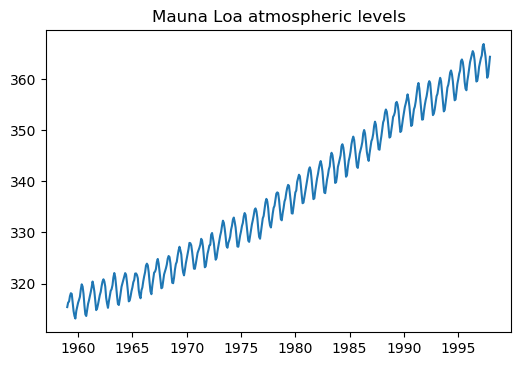

In [8]:
fig,ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.plot(X,y)
plt.title("Mauna Loa atmospheric levels")

## GP regression

Evidently, the data exhibits multiple trends, at different time-scales. We will specify a composite kernel that can hopefully extract meaningful structure in the data. GPy allows us to easily define a composite kernel as follows:

In [9]:
# Linear * Squared Exponential, for long term trend
k11 = GPy.kern.RBF(1, variance=np.exp(4.), lengthscale=np.exp(4.)) 
k12 = GPy.kern.Linear(1)
k1 = k11 * k12

# Periodic * Squared Exponential, for seasonal component
k21 = GPy.kern.PeriodicExponential(1, variance=np.exp(1.), lengthscale=1., period=1.)
k22 = GPy.kern.RBF(1, np.exp(4.), 1.) 
k2 = k21 * k22 

# Rational Quadratic * Squared Exponential, for fluctuations with different length scales
k31 = GPy.kern.RatQuad(1, variance=1., lengthscale=1., power=np.exp(-1.))
k32 = GPy.kern.RBF(1, variance=np.exp(4.), lengthscale=1.) 
k3 = k31 * k32

k = k1 + k2 + k3

In [10]:
m = GPy.models.GPRegression(X_train,y_train,k)

In [11]:
# meanLinear = GPy.mappings.Linear(1,1)
# meanLinear.update_gradients()
# meanConst = GPy.mappings.Constant(1, 1, value=-2360)
# mean = GPy.mappings.Additive(meanLinear, meanConst)
# m = GPy.models.GPRegression(X,y,k,mean_function=mean)

In [12]:
m.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = 222.35552231495134
Optimization restart 2/3, f = 313.44470538463656
Optimization restart 3/3, f = 626.9643723946643


In [13]:
display(m)

GP_regression.,value,constraints,priors
sum.mul.rbf.variance,54.595183557948964,+ve,
sum.mul.rbf.lengthscale,54.607448921166366,+ve,
sum.mul.linear.variances,0.9365118277000614,+ve,
sum.mul_1.periodic_exponential.variance,2.234132948925111,+ve,
sum.mul_1.periodic_exponential.lengthscale,1.7343573923681495,+ve,
sum.mul_1.periodic_exponential.period,0.9948627426752064,+ve,
sum.mul_1.rbf.variance,54.56994455740672,+ve,
sum.mul_1.rbf.lengthscale,3.686439834633242,+ve,
sum.mul_2.RatQuad.variance,0.5694822562392887,+ve,
sum.mul_2.RatQuad.lengthscale,1.54331278007399,+ve,


In [14]:
def addConfidenceBounds(ax,x,mu,s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def removeConfidenceBounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

Interestingly, we have chosen each kernel to be responsible for modelling a unique aspect of the data. This allows us to decompose the overall structure into separate components for closer examination. For instance, we can determine the amplitude and periodicity of the seasonal component from the plot below.

The red dashed line marks the end of our training data, and the start of our test data. The shaded region represents the 95% confidence bound of our predictions. Notice how the confidence bound widens as we extrapolate out of the training data.

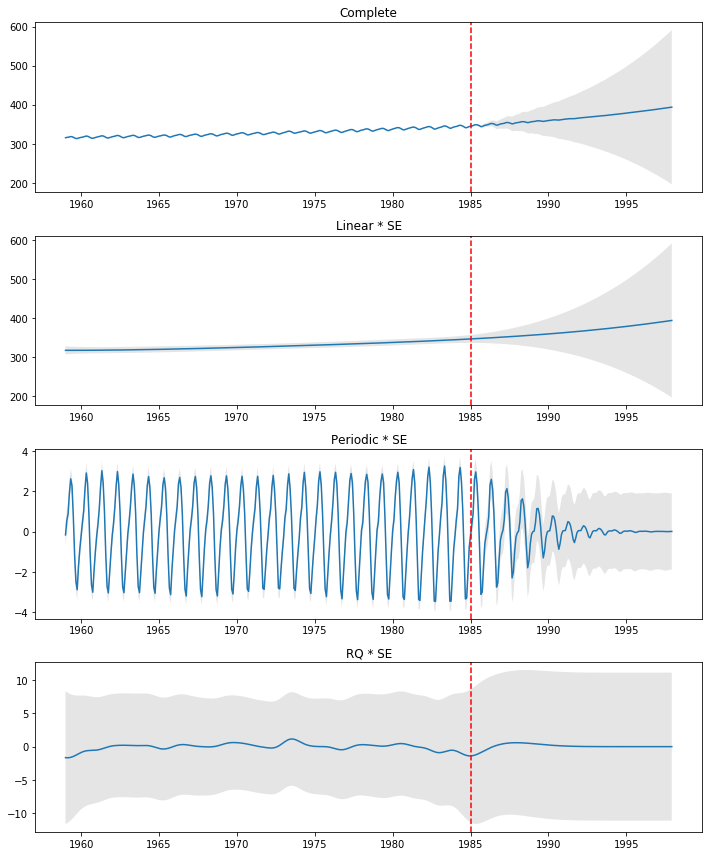

In [15]:
kernel_list = [k] + k.parts
fig, axs = plt.subplots(len(kernel_list),1, figsize=(10, 12), facecolor='w', edgecolor='k')  
axs = axs.ravel()
x_end_training = X_train[-1]
titles = ["Complete","Linear * SE","Periodic * SE","RQ * SE"]
for i,ker in enumerate(kernel_list):
    mu,s2 = m.predict(X,kern = ker)
    s = np.sqrt(s2)
    axs[i].plot(X,mu)
    addConfidenceBounds(axs[i],X,mu,s)
    axs[i].axvline(x_end_training,color='r', linestyle="dashed")
    axs[i].set_title(titles[i])
plt.tight_layout()

## Putting it all back together

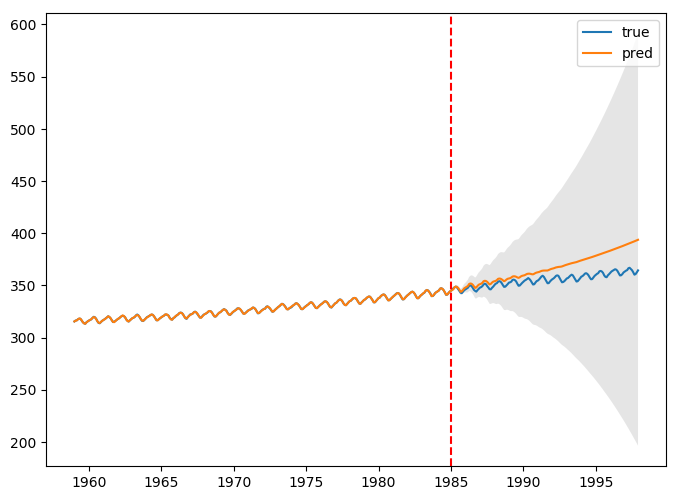

In [16]:
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=100)
y_mu,y_s2 = m.predict(X)
y_s = np.sqrt(y_s2)
ax.plot(X,y,label="true")
ax.plot(X,y_mu,label="pred")
addConfidenceBounds(ax,X,y_mu,y_s)
ax.axvline(x_end_training,color='r', linestyle="dashed")
plt.legend()

In [17]:
np.mean(m.log_predictive_density(X_test, y_test))

-4.090864484412139

In [18]:
np.mean(m.log_predictive_density(X_train, y_train))

0.2464177506265336